# Coupled updraft/downdraft ensembles

Thomas Schanzer  
January 2022

In this notebook, we generate and analyse ensembles of coupled updrafts and downdrafts with different entrainment rates and initial conditions, examining the distributions of velocity profiles.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import sys
import random

import metpy.calc as mpcalc
from metpy.units import units, concatenate

from dparcel.thermo import (saturation_specific_humidity,
                            equivalent_potential_temperature)
sys.path.append('../convection_scheme')
from coupler import Coupler
from thermal_generator import ThermalGenerator

## Singapore

In [25]:
file = ('test_soundings/48698 WSSS Singapore Observations '
        'at 00Z 01 Dec 2021.txt')
sounding = pd.read_fwf(file, usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure_raw = sounding[:2:-1,0]
height_raw = sounding[:2:-1,1]
temperature_raw = sounding[:2:-1,2]
dewpoint_raw = sounding[:2:-1,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], 5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
height -= height[-1]
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)
coupler = Coupler(pressure, height, temperature, specific_humidity)

### Varying entrainment rate, no drag

In [140]:
# updraft parameters
i_init = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init], temperature[i_init])
     - specific_humidity[i_init]
)
l_initial = 0*units.dimensionless
l_crit = 2.0e-3*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
epsilon = np.arange(0.05, 1.01, 0.05)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [141]:
updrafts = np.zeros(epsilon.size, dtype='object')
downdrafts1 = np.zeros(epsilon.size, dtype='object')
downdrafts2 = np.zeros(epsilon.size, dtype='object')
downdrafts3 = np.zeros(epsilon.size, dtype='object')
n_done = 0
for i in range(epsilon.size):
    n_done += 1
    sys.stdout.write(f'\rCalculation {n_done} of {epsilon.size}    ')
    updrafts[i], downdrafts1[i], downdrafts2[i] = coupler.precipitation_driven(
        i_init, t_pert, q_pert, l_initial, w_initial,
        epsilon[i], dnu_db, drag, l_crit, basic=True)
    _, downdrafts3[i] = coupler.overshooting(
        i_init, t_pert, q_pert, l_initial, w_initial,
        epsilon[i], dnu_db, drag, l_crit, basic=True)

Calculation 20 of 20    

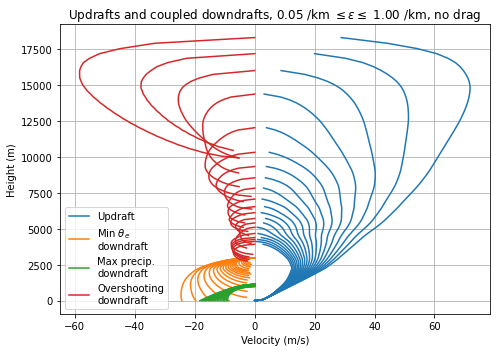

In [142]:
fig, ax = plt.subplots(figsize=(7,5))
lines = ax.plot(
    concatenate([[u.velocity] for u in updrafts]).T, height,
    'tab:blue', label='Updraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts1]).T, height,
    'tab:orange', label='Min $\\theta_e$\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts2]).T, height,
    'tab:green', label='Max precip.\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts3]).T, height,
    'tab:red', label='Overshooting\ndowndraft')
plt.setp(lines[1:], label="_")
ax.grid()
ax.legend()
ax.set(
    xlabel='Velocity (m/s)', ylabel='Height (m)',
    title='Updrafts and coupled downdrafts, '
          '0.05 /km $\\leq \\epsilon \\leq$ 1.00 /km, no drag')
fig.tight_layout()

### Varying entrainment rate, with drag

In [143]:
# updraft parameters
i_init = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init], temperature[i_init])
     - specific_humidity[i_init]
)
l_initial = 0*units.dimensionless
l_crit = 2.0e-3*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
epsilon = np.arange(0.05, 1.01, 0.05)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0.5/units.km

In [144]:
updrafts = np.zeros(epsilon.size, dtype='object')
downdrafts1 = np.zeros(epsilon.size, dtype='object')
downdrafts2 = np.zeros(epsilon.size, dtype='object')
downdrafts3 = np.zeros(epsilon.size, dtype='object')
n_done = 0
for i in range(epsilon.size):
    n_done += 1
    sys.stdout.write(f'\rCalculation {n_done} of {epsilon.size}    ')
    updrafts[i], downdrafts1[i], downdrafts2[i] = coupler.precipitation_driven(
        i_init, t_pert, q_pert, l_initial, w_initial,
        epsilon[i], dnu_db, drag, l_crit, basic=True)
    _, downdrafts3[i] = coupler.overshooting(
        i_init, t_pert, q_pert, l_initial, w_initial,
        epsilon[i], dnu_db, drag, l_crit, basic=True)

Calculation 20 of 20    

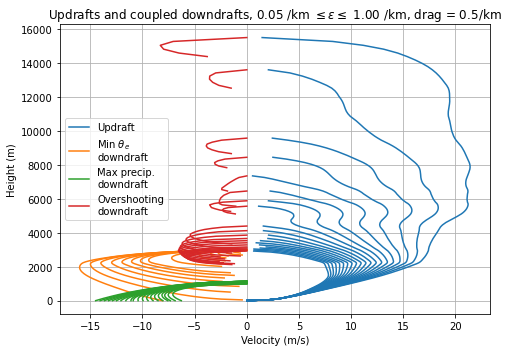

In [145]:
fig, ax = plt.subplots(figsize=(7,5))
lines = ax.plot(
    concatenate([[u.velocity] for u in updrafts]).T, height,
    'tab:blue', label='Updraft')
plt.setp(lines[1:], label="_")
downdrafts1_filt = []
for d in downdrafts1:
    if d is not None:
        downdrafts1_filt.append(d)
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts1_filt]).T, height,
    'tab:orange', label='Min $\\theta_e$\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts2]).T, height,
    'tab:green', label='Max precip.\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts3]).T, height,
    'tab:red', label='Overshooting\ndowndraft')
plt.setp(lines[1:], label="_")
ax.grid()
ax.legend()
ax.set(
    xlabel='Velocity (m/s)', ylabel='Height (m)',
    title='Updrafts and coupled downdrafts, '
          '0.05 /km $\\leq \\epsilon \\leq$ 1.00 /km, drag = 0.5/km')
fig.tight_layout()

### Varying initial temperature

In [15]:
# updraft parameters
i_init = pressure.size - 1
t_pert = np.arange(0.1, 2.01, 0.1)*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init], temperature[i_init])
     - specific_humidity[i_init]
)
l_initial = 0*units.dimensionless
l_crit = 2.0e-3*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
epsilon = 0.5/units.km
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [16]:
updrafts = np.zeros(t_pert.size, dtype='object')
downdrafts1 = np.zeros(t_pert.size, dtype='object')
downdrafts2 = np.zeros(t_pert.size, dtype='object')
downdrafts3 = np.zeros(t_pert.size, dtype='object')
n_done = 0
for i in range(t_pert.size):
    n_done += 1
    sys.stdout.write(f'\rCalculation {n_done} of {t_pert.size}    ')
    updrafts[i], downdrafts1[i], downdrafts2[i] = coupler.precipitation_driven(
        i_init, t_pert[i], q_pert, l_initial, w_initial,
        epsilon, dnu_db, drag, l_crit, basic=True)
    _, downdrafts3[i] = coupler.overshooting(
        i_init, t_pert[i], q_pert, l_initial, w_initial,
        epsilon, dnu_db, drag, l_crit, basic=True)

Calculation 20 of 20    

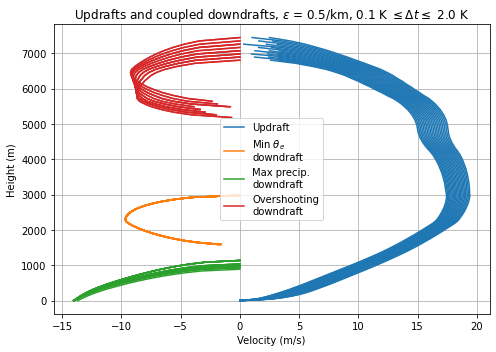

In [17]:
fig, ax = plt.subplots(figsize=(7,5))
lines = ax.plot(
    concatenate([[u.velocity] for u in updrafts]).T, height,
    'tab:blue', label='Updraft')
plt.setp(lines[1:], label="_")
downdrafts1_filt = []
for d in downdrafts1:
    if d is not None:
        downdrafts1_filt.append(d)
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts1_filt]).T, height,
    'tab:orange', label='Min $\\theta_e$\ndowndraft')
plt.setp(lines[1:], label="_")
downdrafts2_filt = []
for d in downdrafts2:
    if d is not None:
        downdrafts2_filt.append(d)
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts2_filt]).T, height,
    'tab:green', label='Max precip.\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts3]).T, height,
    'tab:red', label='Overshooting\ndowndraft')
plt.setp(lines[1:], label="_")
ax.grid()
ax.legend()
ax.set(
    xlabel='Velocity (m/s)', ylabel='Height (m)',
    title='Updrafts and coupled downdrafts, '
          '$\\epsilon$ = 0.5/km, 0.1 K $\\leq \\Delta t \\leq$ 2.0 K')
fig.tight_layout()

### Varying initial specific humidity

In [18]:
# updraft parameters
i_init = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init], temperature[i_init])
     - specific_humidity[i_init]
)*np.arange(0, 1.01, 0.05)
l_initial = 0*units.dimensionless
l_crit = 2.0e-3*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
epsilon = 0.5/units.km
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [19]:
updrafts = np.zeros(q_pert.size, dtype='object')
downdrafts1 = np.zeros(q_pert.size, dtype='object')
downdrafts2 = np.zeros(q_pert.size, dtype='object')
downdrafts3 = np.zeros(q_pert.size, dtype='object')
n_done = 0
for i in range(q_pert.size):
    n_done += 1
    sys.stdout.write(f'\rCalculation {n_done} of {q_pert.size}    ')
    updrafts[i], downdrafts1[i], downdrafts2[i] = coupler.precipitation_driven(
        i_init, t_pert, q_pert[i], l_initial, w_initial,
        epsilon, dnu_db, drag, l_crit, basic=True)
    _, downdrafts3[i] = coupler.overshooting(
        i_init, t_pert, q_pert[i], l_initial, w_initial,
        epsilon, dnu_db, drag, l_crit, basic=True)

Calculation 21 of 21    

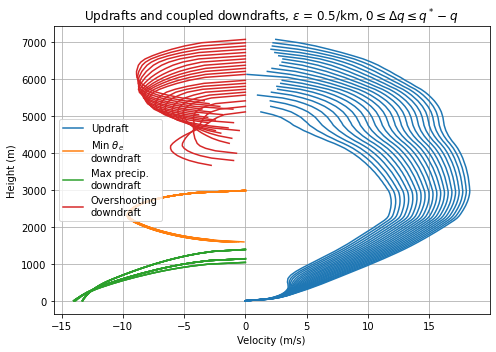

In [27]:
fig, ax = plt.subplots(figsize=(7,5))
lines = ax.plot(
    concatenate([[u.velocity] for u in updrafts]).T, height,
    'tab:blue', label='Updraft')
plt.setp(lines[1:], label="_")
downdrafts1_filt = []
for d in downdrafts1:
    if d is not None:
        downdrafts1_filt.append(d)
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts1_filt]).T, height,
    'tab:orange', label='Min $\\theta_e$\ndowndraft')
plt.setp(lines[1:], label="_")
downdrafts2_filt = []
for d in downdrafts2:
    if d is not None:
        downdrafts2_filt.append(d)
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts2_filt]).T, height,
    'tab:green', label='Max precip.\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts3]).T, height,
    'tab:red', label='Overshooting\ndowndraft')
plt.setp(lines[1:], label="_")
ax.grid()
ax.legend(loc='center left')
ax.set(
    xlabel='Velocity (m/s)', ylabel='Height (m)',
    title='Updrafts and coupled downdrafts, '
          '$\\epsilon$ = 0.5/km, $0 \\leq \\Delta q \\leq q^* - q$')
fig.tight_layout()

## Williamtown

In [28]:
file = ('test_soundings/94776 YSWM Williamtown Amo Raaf Observations '
        'at 00Z 21 Dec 2021.txt')
sounding = pd.read_fwf(file, usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure_raw = sounding[:2:-1,0]
height_raw = sounding[:2:-1,1]
temperature_raw = sounding[:2:-1,2]
dewpoint_raw = sounding[:2:-1,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], 5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
height -= height[-1]
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)
coupler = Coupler(pressure, height, temperature, specific_humidity)

### Varying entrainment rate, no drag

In [147]:
# updraft parameters
i_init = np.argmin(np.abs(pressure - 900*units.mbar))
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init], temperature[i_init])
     - specific_humidity[i_init]
)
l_initial = 0*units.dimensionless
l_crit = 2.0e-3*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
epsilon = np.arange(0.05, 1.01, 0.05)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [148]:
updrafts = np.zeros(epsilon.size, dtype='object')
downdrafts1 = np.zeros(epsilon.size, dtype='object')
downdrafts2 = np.zeros(epsilon.size, dtype='object')
downdrafts3 = np.zeros(epsilon.size, dtype='object')
n_done = 0
for i in range(epsilon.size):
    n_done += 1
    sys.stdout.write(f'\rCalculation {n_done} of {epsilon.size}    ')
    updrafts[i], downdrafts1[i], downdrafts2[i] = coupler.precipitation_driven(
        i_init, t_pert, q_pert, l_initial, w_initial,
        epsilon[i], dnu_db, drag, l_crit, basic=True)
    _, downdrafts3[i] = coupler.overshooting(
        i_init, t_pert, q_pert, l_initial, w_initial,
        epsilon[i], dnu_db, drag, l_crit, basic=True)

Calculation 20 of 20    

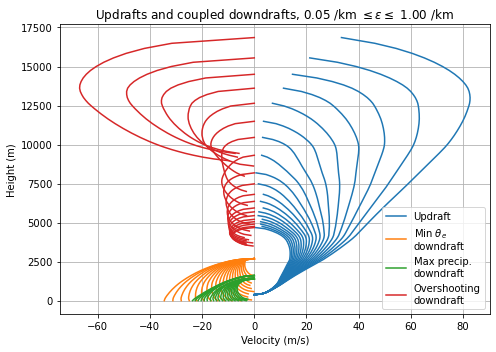

In [149]:
fig, ax = plt.subplots(figsize=(7,5))
lines = ax.plot(
    concatenate([[u.velocity] for u in updrafts]).T, height,
    'tab:blue', label='Updraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts1]).T, height,
    'tab:orange', label='Min $\\theta_e$\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts2]).T, height,
    'tab:green', label='Max precip.\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts3]).T, height,
    'tab:red', label='Overshooting\ndowndraft')
plt.setp(lines[1:], label="_")
ax.grid()
ax.legend()
ax.set(
    xlabel='Velocity (m/s)', ylabel='Height (m)',
    title='Updrafts and coupled downdrafts, '
          '0.05 /km $\\leq \\epsilon \\leq$ 1.00 /km')
fig.tight_layout()

### Varying entrainment rate, with drag

In [150]:
# updraft parameters
i_init = np.argmin(np.abs(pressure - 900*units.mbar))

t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init], temperature[i_init])
     - specific_humidity[i_init]
)
l_initial = 0*units.dimensionless
l_crit = 2.0e-3*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
epsilon = np.arange(0.05, 1.01, 0.05)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0.5/units.km

In [151]:
updrafts = np.zeros(epsilon.size, dtype='object')
downdrafts1 = np.zeros(epsilon.size, dtype='object')
downdrafts2 = np.zeros(epsilon.size, dtype='object')
downdrafts3 = np.zeros(epsilon.size, dtype='object')
n_done = 0
for i in range(epsilon.size):
    n_done += 1
    sys.stdout.write(f'\rCalculation {n_done} of {epsilon.size}    ')
    updrafts[i], downdrafts1[i], downdrafts2[i] = coupler.precipitation_driven(
        i_init, t_pert, q_pert, l_initial, w_initial,
        epsilon[i], dnu_db, drag, l_crit, basic=True)
    _, downdrafts3[i] = coupler.overshooting(
        i_init, t_pert, q_pert, l_initial, w_initial,
        epsilon[i], dnu_db, drag, l_crit, basic=True)

Calculation 20 of 20    

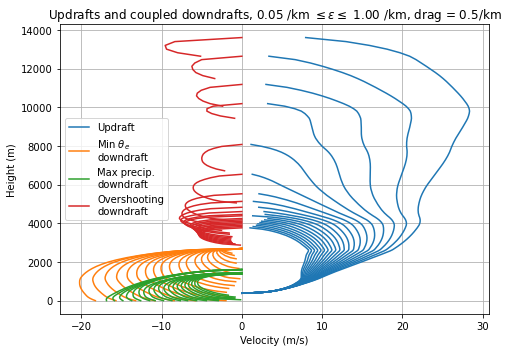

In [152]:
fig, ax = plt.subplots(figsize=(7,5))
lines = ax.plot(
    concatenate([[u.velocity] for u in updrafts]).T, height,
    'tab:blue', label='Updraft')
plt.setp(lines[1:], label="_")
downdrafts1_filt = []
for d in downdrafts1:
    if d is not None:
        downdrafts1_filt.append(d)
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts1_filt]).T, height,
    'tab:orange', label='Min $\\theta_e$\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts2]).T, height,
    'tab:green', label='Max precip.\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts3]).T, height,
    'tab:red', label='Overshooting\ndowndraft')
plt.setp(lines[1:], label="_")
ax.grid()
ax.legend()
ax.set(
    xlabel='Velocity (m/s)', ylabel='Height (m)',
    title='Updrafts and coupled downdrafts, '
          '0.05 /km $\\leq \\epsilon \\leq$ 1.00 /km, drag = 0.5/km')
fig.tight_layout()

### Varying initial temperature

In [29]:
# updraft parameters
i_init = np.argmin(np.abs(pressure - 900*units.mbar))
t_pert = np.arange(0.1, 2.01, 0.1)*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init], temperature[i_init])
     - specific_humidity[i_init]
)
l_initial = 0*units.dimensionless
l_crit = 2.0e-3*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
epsilon = 0.5/units.km
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [30]:
updrafts = np.zeros(t_pert.size, dtype='object')
downdrafts1 = np.zeros(t_pert.size, dtype='object')
downdrafts2 = np.zeros(t_pert.size, dtype='object')
downdrafts3 = np.zeros(t_pert.size, dtype='object')
n_done = 0
for i in range(t_pert.size):
    n_done += 1
    sys.stdout.write(f'\rCalculation {n_done} of {t_pert.size}    ')
    updrafts[i], downdrafts1[i], downdrafts2[i] = coupler.precipitation_driven(
        i_init, t_pert[i], q_pert, l_initial, w_initial,
        epsilon, dnu_db, drag, l_crit, basic=True)
    _, downdrafts3[i] = coupler.overshooting(
        i_init, t_pert[i], q_pert, l_initial, w_initial,
        epsilon, dnu_db, drag, l_crit, basic=True)

Calculation 20 of 20    

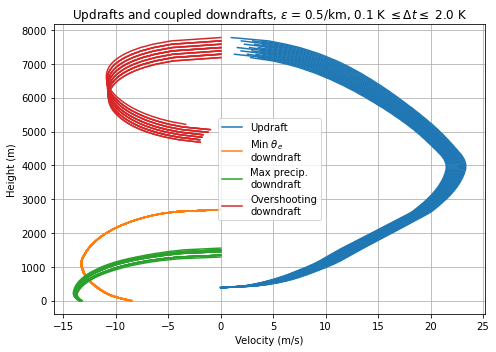

In [31]:
fig, ax = plt.subplots(figsize=(7,5))
lines = ax.plot(
    concatenate([[u.velocity] for u in updrafts]).T, height,
    'tab:blue', label='Updraft')
plt.setp(lines[1:], label="_")
downdrafts1_filt = []
for d in downdrafts1:
    if d is not None:
        downdrafts1_filt.append(d)
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts1_filt]).T, height,
    'tab:orange', label='Min $\\theta_e$\ndowndraft')
plt.setp(lines[1:], label="_")
downdrafts2_filt = []
for d in downdrafts2:
    if d is not None:
        downdrafts2_filt.append(d)
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts2_filt]).T, height,
    'tab:green', label='Max precip.\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts3]).T, height,
    'tab:red', label='Overshooting\ndowndraft')
plt.setp(lines[1:], label="_")
ax.grid()
ax.legend()
ax.set(
    xlabel='Velocity (m/s)', ylabel='Height (m)',
    title='Updrafts and coupled downdrafts, '
          '$\\epsilon$ = 0.5/km, 0.1 K $\\leq \\Delta t \\leq$ 2.0 K')
fig.tight_layout()

### Varying initial specific humidity

In [32]:
# updraft parameters
i_init = np.argmin(np.abs(pressure - 900*units.mbar))
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init], temperature[i_init])
     - specific_humidity[i_init]
)*np.arange(0, 1.01, 0.05)
l_initial = 0*units.dimensionless
l_crit = 2.0e-3*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
epsilon = 0.5/units.km
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [33]:
updrafts = np.zeros(q_pert.size, dtype='object')
downdrafts1 = np.zeros(q_pert.size, dtype='object')
downdrafts2 = np.zeros(q_pert.size, dtype='object')
downdrafts3 = np.zeros(q_pert.size, dtype='object')
n_done = 0
for i in range(q_pert.size):
    n_done += 1
    sys.stdout.write(f'\rCalculation {n_done} of {q_pert.size}    ')
    updrafts[i], downdrafts1[i], downdrafts2[i] = coupler.precipitation_driven(
        i_init, t_pert, q_pert[i], l_initial, w_initial,
        epsilon, dnu_db, drag, l_crit, basic=True)
    _, downdrafts3[i] = coupler.overshooting(
        i_init, t_pert, q_pert[i], l_initial, w_initial,
        epsilon, dnu_db, drag, l_crit, basic=True)

Calculation 21 of 21    

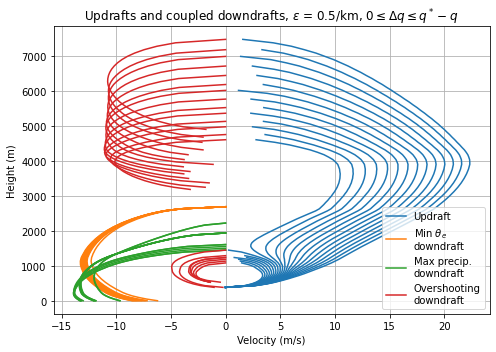

In [35]:
fig, ax = plt.subplots(figsize=(7,5))
lines = ax.plot(
    concatenate([[u.velocity] for u in updrafts]).T, height,
    'tab:blue', label='Updraft')
plt.setp(lines[1:], label="_")
downdrafts1_filt = []
for d in downdrafts1:
    if d is not None:
        downdrafts1_filt.append(d)
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts1_filt]).T, height,
    'tab:orange', label='Min $\\theta_e$\ndowndraft')
plt.setp(lines[1:], label="_")
downdrafts2_filt = []
for d in downdrafts2:
    if d is not None:
        downdrafts2_filt.append(d)
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts2_filt]).T, height,
    'tab:green', label='Max precip.\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts3]).T, height,
    'tab:red', label='Overshooting\ndowndraft')
plt.setp(lines[1:], label="_")
ax.grid()
ax.legend(loc='lower right')
ax.set(
    xlabel='Velocity (m/s)', ylabel='Height (m)',
    title='Updrafts and coupled downdrafts, '
          '$\\epsilon$ = 0.5/km, $0 \\leq \\Delta q \\leq q^* - q$')
fig.tight_layout()

## Discussion
- With the addition of overshooting downdrafts, the ensemble results support the conclusions of Torri and Kuang (2016): "although there are downdrafts at all heights, they do not travel much farther than a few hundred meters"
    - With drag, the precipitation-driven downdrafts tend to be stronger and penetrate further than the overshooting ones. This is also supported by Torri and Kuang (2016), who found that near-surface downdrafts are the most prevalent type (see their Figure 4).
- The addition of drag can reduce velocities to much more realistic values
    - This is consistent with the results of Romps and Charn (2015), who found that the dominant balance in a thermal's momentum budget is between buoyancy and drag (perturbation pressure gradient forces), i.e., thermals are "sticky" rather than "slippery".
    - Without drag, under the assumption that downdrafts have the same entrainment rate as the updrafts that caused them, overshooting downdrafts from weakly entraining updrafts can attain unrealistically high velocities. With drag, all the overshooting downdrafts attain similar, smaller, speeds.
- The variation of entrainment produces a much wider spread of updraft and downdraft velocity profiles than the variation of initial conditions, consistent with the findings of Romps and Kuang (2010).
    - Changing the initial conditions has only a very small effect on the strength of the coupled downdrafts.
    
| Torri and Kuang (2016) | Romps and Charn (2015) | Romps and Kuang (2010) |
| ---------------------- | ---------------------- | ---------------------- |
| 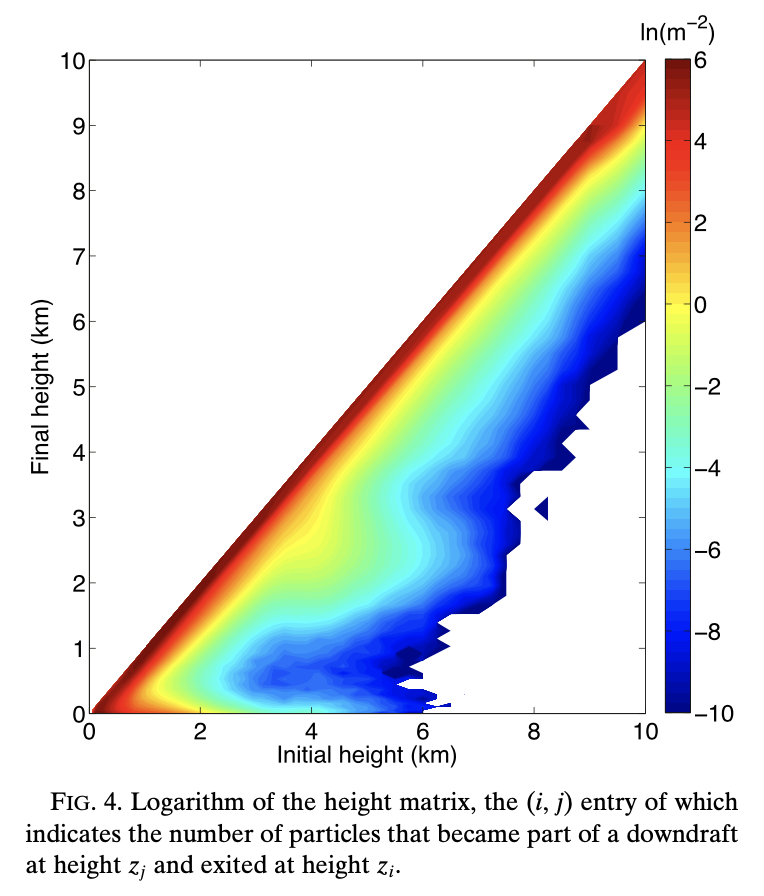 | 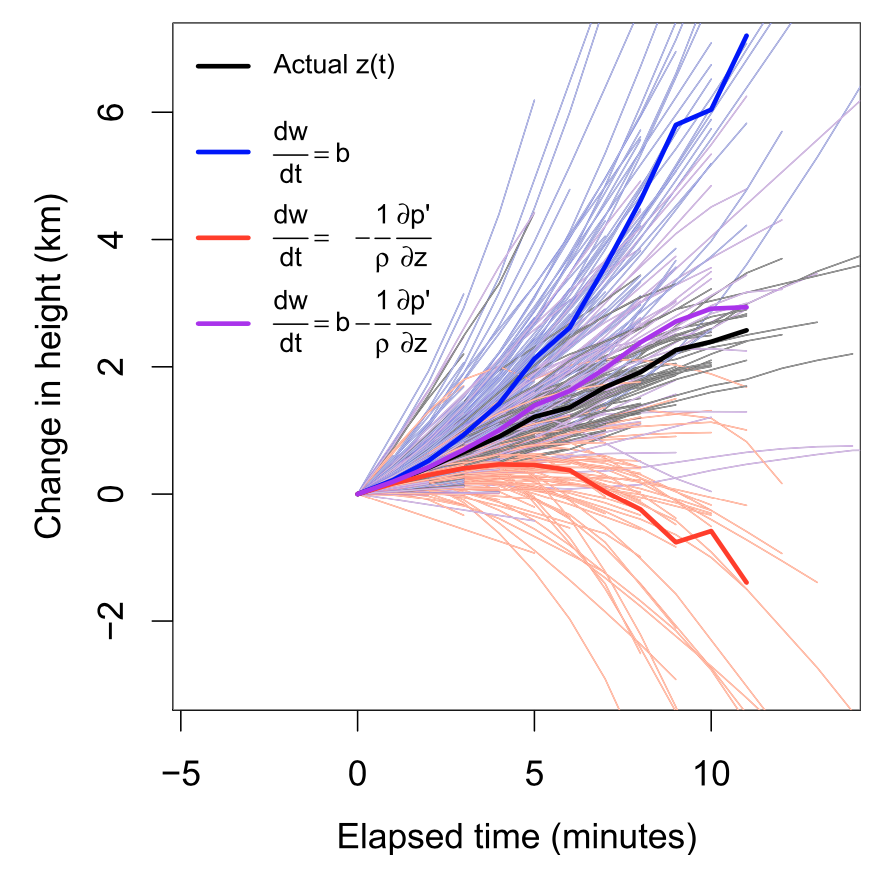 | 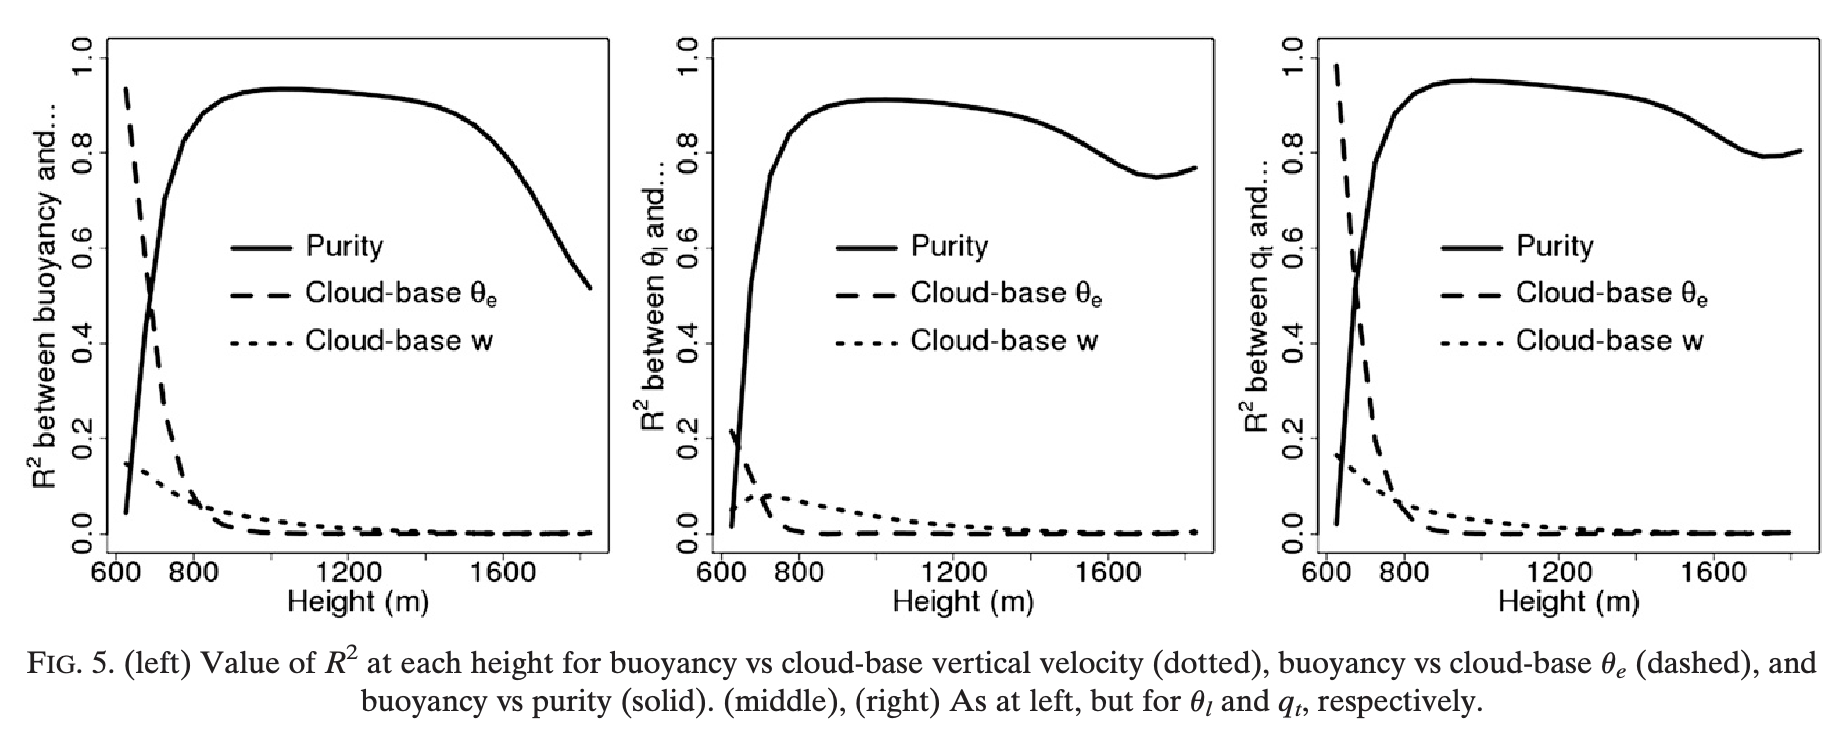 |

## Conclusions
- The combination of precipitation-driven and overshooting downdrafts, originating from updrafts with a uniform spectrum of entrainment rates, seems to produce a realistic spread of convective activity throughout the sounding that is consistent with the literature.
- Some drag is needed to achieve realistic velocities, and reduces the penetration distance of overshooting downdrafts to realistic values.
- The ensemble can be created by variation of entrainment rate alone, as the effect of changing the initial conditions, especially on the downdrafts, is negligible.